# Imports

In [1]:
# Libraries 
import os
import datetime
import pickle
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from tensorflow.keras.models import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
import seaborn as sns
import importlib
import random

# Python files
import functions_nn_2

In [2]:
importlib.reload(functions_nn_2)
from functions_nn_2 import *

# Load Data

In [3]:
df = pd.read_csv("macro_monthly_clean.csv")

# Change from object to datetime, set as index
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)

# Model

## Configs

In [4]:
# Specify target variable and features
features = ['unrate', 'psr', 'm2', 'dspic', 'pce', 'ir', 'ffer', 'indpro', 'ccpi']
#features = ['unrate']
target = "unrate"

# Specify input and output length
input_sequence_length = 9
output_sequence_length = 1

## Fine tune data

In [5]:
# From df prepare the dataframe for use
arr_features_unscaled, arr_target_unscaled, df_features = prepare_data(df, features, target)
index_target = df_features.columns.get_loc("unrate") # Find index of the target variable column

# Get Index of each dataframe
train_data_length = df.shape[0] - df[df.index.year >= 2000].shape[0]
val_data_length = train_data_length + df[(df.index.year >= 2000) & (df.index.year < 2021)].shape[0]

# Select the x axis values for the actual vs. pred graph
x_values = df.index[val_data_length:]

In [6]:
# Scale each feature to a range between 0 and 1
scaler_train = MinMaxScaler()
arr_features_scaled = scaler_train.fit_transform(arr_features_unscaled)
    
# Create a separate scaler for a single column
scaler_pred = MinMaxScaler()
arr_target_scaled = scaler_pred.fit_transform(arr_target_unscaled)   

# Create the training and test data
train_data = arr_features_scaled[:train_data_length, :]
val_data = arr_features_scaled[train_data_length- input_sequence_length:val_data_length, :]
test_data = arr_features_scaled[val_data_length - input_sequence_length:, :]

# Check shapes
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)


(228, 9)
(261, 9)
(19, 9)


In [7]:
# Generate training data, val and test data
x_train, y_train = partition_dataset(input_sequence_length, output_sequence_length, train_data, index_target)
x_val, y_val = partition_dataset(input_sequence_length, output_sequence_length, val_data, index_target)
x_test, y_test = partition_dataset(input_sequence_length, output_sequence_length, test_data, index_target)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(219, 9, 9) (219, 1)
(252, 9, 9) (252, 1)
(10, 9, 9) (10, 1)


## Train model

In [8]:
from itertools import product

# Configs
epochs = 500
batch_size = 64
patience = 30
model_type = "regularized"
lstm_units1 = 128
lstm_units2 = 64

# Define the hyperparameter search space
learning_rates = [0.001, 0.0001, 0.00001]
l2_regs = [0.01, 0.001, 0.0001]
l1_regs = [0.01, 0.001, 0.0001]
dropout_rates = [0.2, 0.3, 0.4]

best_hyperparameters = None
best_mape = float('inf')
best_mae = float('inf')
best_mse = float('inf')

# Perform grid search
for lr, l2, l1, dropout in product(learning_rates, l2_regs, l1_regs, dropout_rates):
    # Update hyperparameters
    learning_rate = lr
    l2_reg = l2
    l1_reg = l1
    dropout_rate = dropout

    # Create and train the model with the current hyperparameters
    model = create_lstm_model(model_type, x_train, output_sequence_length, l2_reg, l1_reg, dropout_rate, lstm_units1, lstm_units2, learning_rate)
    history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_val, y_val), callbacks=[EarlyStopping(patience=patience)])

    # Get the predicted values
    y_pred_scaled = model.predict(x_test)

    # Unscale the predicted values
    y_pred = scaler_pred.inverse_transform(y_pred_scaled)
    y_test_unscaled = scaler_pred.inverse_transform(y_test).reshape(-1, output_sequence_length)

    # Mean Absolute Error (MAE)
    MAE = mean_absolute_error(y_test_unscaled, y_pred)

    # Mean Squared Error (MSE)
    MSE = mean_squared_error(y_test_unscaled, y_pred)

    # Mean Absolute Percentage Error (MAPE)
    MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred) / y_test_unscaled))) * 100

    # Check if this run has the best MAPE so far
    if MAPE < best_mape:
        best_mape = MAPE
        best_mae = MAE
        best_mse = MSE
        best_hyperparameters = (lr, l2, l1, dropout)  # Save the best hyperparameters
        best_model = model  # Save the best model
        best_predictions = y_pred  # Save the best predictions
        best_train_loss = history.history['loss']     # Save the training loss of the best run
        best_val_loss = history.history['val_loss']    # Save the validation loss of the best run

# Print the best hyperparameters and performance metrics
best_learning_rate, best_l2_reg, best_l1_reg, best_dropout_rate = best_hyperparameters
print(f'Best Learning Rate: {best_learning_rate}')
print(f'Best L2 Regularization: {best_l2_reg}')
print(f'Best L1 Regularization: {best_l1_reg}')
print(f'Best Dropout Rate: {best_dropout_rate}')
print(f'Best MAE: {np.round(best_mae, 2)}')
print(f'Best MSE: {np.round(best_mse, 2)}')
print(f'Best MAPE: {np.round(best_mape, 2)} %')


Epoch 1/500
7/7 [==============================] - 4s 124ms/step - loss: 2.1964 - val_loss: 2.2080
Epoch 2/500
7/7 [==============================] - 0s 17ms/step - loss: 1.7979 - val_loss: 1.8771
Epoch 3/500
7/7 [==============================] - 0s 18ms/step - loss: 1.4980 - val_loss: 1.5573
Epoch 4/500
7/7 [==============================] - 0s 17ms/step - loss: 1.2530 - val_loss: 1.3059
Epoch 5/500
7/7 [==============================] - 0s 18ms/step - loss: 1.0500 - val_loss: 1.0990
Epoch 6/500
7/7 [==============================] - 0s 17ms/step - loss: 0.8822 - val_loss: 0.9285
Epoch 7/500
7/7 [==============================] - 0s 18ms/step - loss: 0.7410 - val_loss: 0.7937
Epoch 8/500
7/7 [==============================] - 0s 18ms/step - loss: 0.6232 - val_loss: 0.6743
Epoch 9/500
7/7 [==============================] - 0s 17ms/step - loss: 0.5254 - val_loss: 0.5761
Epoch 10/500
7/7 [==============================] - 0s 18ms/step - loss: 0.4441 - val_loss: 0.4906
Epoch 11/500
7/7 [

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'results\\random_search'

In [9]:
# Create folder for results
path = 'results'
formatted_datetime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
folder_name = f"{formatted_datetime}_random_search"
folder_path = os.path.join(path, folder_name)
os.makedirs(folder_path)

# Save Results

In [10]:
# Create a dictionary to store the results
results_dict = {
    "Best MAE": np.round(best_mae, 2),
    "Best MSE": np.round(best_mse, 2),
    "Best MAPE": np.round(best_mape, 2),
    "Best Train Loss": best_train_loss,
    "Best Validation Loss": best_val_loss,
    "Best Predictions": best_predictions.tolist() if best_predictions is not None else None
}

# Specify the custom path for the pickle file
custom_path = os.path.join(folder_path, "results.pkl")

# Save the results dictionary to the custom path as a pickle file
with open(custom_path, 'wb') as file:
    pickle.dump(results_dict, file)

print(f'Results saved to {custom_path}')

# Save the model to the specified path
tf.keras.models.save_model(model, folder_path)

Results saved to results\2023-11-05_21-40-39_random_search\results.pkl
INFO:tensorflow:Assets written to: results\2023-11-05_21-40-39_random_search\assets


INFO:tensorflow:Assets written to: results\2023-11-05_21-40-39_random_search\assets


# Results

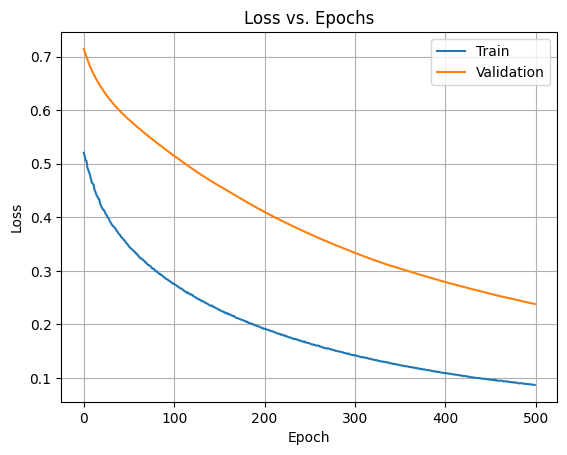

In [11]:
# Set name of file
save_path = os.path.join(folder_path, "loss.png")

plt.plot(best_train_loss, label='Train')
plt.plot(best_val_loss, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.savefig(save_path)
plt.show()

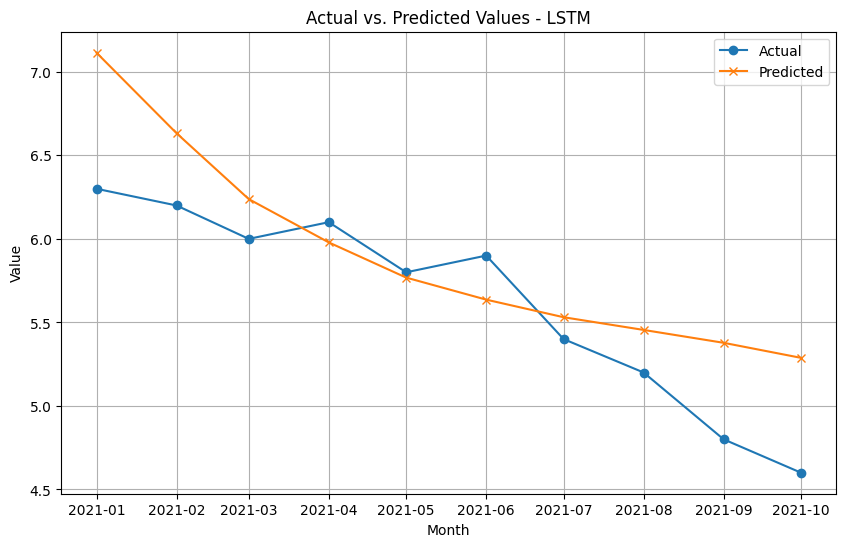

In [13]:
# Set name of file
save_path = os.path.join(folder_path, "actualvspred.png")

# Create a range of indices for the x-axis
indices = range(len(y_test_unscaled))

# Plot the actual values (y_test_unscaled) vs. predicted values (y_pred)
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_test_unscaled, label='Actual', marker='o')
plt.plot(x_values, best_predictions, label='Predicted', marker='x')
plt.xlabel('Month')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values - LSTM')
plt.legend()
plt.grid(True)
plt.savefig(save_path)
plt.show()